In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tqdm

In [89]:
game_stats = pd.read_csv('../csv/game_stats.csv')
game_stats["totalGoals"] = game_stats["home_goals"] + game_stats["away_goals"]
game_stats = game_stats[game_stats["totalGoals"] < 10]  # remove outliers 99% of games will be kept
del game_stats["Unnamed: 0"]
del game_stats["home_goals"]
del game_stats["away_goals"]
del game_stats["home_powerPlayGoals"]
del game_stats["away_powerPlayGoals"]
del game_stats["home_powerPlayOpportunities"]
del game_stats["away_powerPlayOpportunities"]

game_stats = game_stats.drop_duplicates()
game_stats = game_stats.dropna()

game_stats

,home_pim,home_shots,home_powerPlayPercentage,home_faceOffWinPercentage,home_blocked,home_takeaways,home_giveaways,home_hits,away_pim,away_shots,away_powerPlayPercentage,away_faceOffWinPercentage,away_blocked,away_takeaways,away_giveaways,away_hits,totalGoals
2,10,29,0.0,68.2,17,5,2,23,12,15,33.3,31.8,8,6,4,23,6
5,10,27,0.0,51.6,13,8,16,45,4,40,40.0,48.4,4,3,9,22,4
9,4,41,50.0,41.4,18,4,10,24,4,15,50.0,58.6,11,4,9,13,7
10,2,46,50.0,45.6,9,8,12,29,6,39,0.0,54.4,13,6,6,20,7
11,2,24,66.7,57.1,7,3,19,23,6,34,0.0,42.9,15,9,9,15,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21383,4,32,0.0,52.6,15,5,9,29,8,19,0.0,47.4,23,6,7,33,4
21384,4,23,0.0,43.9,23,14,19,20,6,24,50.0,56.1,17,8,7,13,3
21386,9,32,0.0,63.6,13,4,12,27,9,37,0.0,36.4,17,7,10,27,7
21390,4,37,75.0,49.0,6,3,11,9,8,21,0.0,51.0,10,3,2,17,5


### Partition Training, Validation, and Testing Data

In [90]:
col_names = [col for col in game_stats.columns]


originalGoals = game_stats["totalGoals"]

# z = (x-mean)/std
# x = (z*std)+mean

original_mean = game_stats.mean()
original_std = game_stats.std()

game_stats_normalized =(game_stats-original_mean)/original_std
game_stats = game_stats_normalized
#game_stats["totalGoals"] = originalGoals

features = np.array(game_stats.loc[:, game_stats.columns != 'totalGoals'],  dtype='float32')
# augment bias term to features
features = np.concatenate((np.ones((features.shape[0], 1)), features), axis=1)
targets = np.array(game_stats['totalGoals'], dtype='float32')


x_train = features[:int(features.shape[0] * 0.8)]
t_train = targets[:int(targets.shape[0] * 0.8)]

x_val = features[int(features.shape[0] * 0.8): int(features.shape[0] * 0.9)]
t_val = targets[int(targets.shape[0] * 0.8): int(targets.shape[0] * 0.9)]

x_test = features[int(features.shape[0] * 0.9):]
t_test = targets[int(targets.shape[0] * 0.9):]

### Train & Analyze Gradient Descent Optimization for Linear Regression Model

In [94]:
# gradient descent algorithm on x_train and t_train:
def gradient_descent(x_train, t_train, x_val, t_val, learning_rate, epochs):
    # initialize theta
    theta = np.random.rand(x_train.shape[1])
    theta_history = []
    costs = []
    best_theta = theta
    best_loss = np.inf
    best_epoch = 0
    for epoch in tqdm.tqdm(range(epochs)):
        # shuffle training data
        indx = np.arange(x_train.shape[0])
        x_train = x_train[indx]
        t_train = t_train[indx]
        
        # mini batch gradient descent
        for i in range(x_train.shape[0]):
            x = x_train[i]
            t = t_train[i]
            y = np.dot(x, theta)
            cost = (y - t) ** 2
            # update theta
            theta -= learning_rate * 2 * x * (y - t)
        # append theta_history
        theta_history.append(theta)
        # calculate cost
        cost = (1 / (2 * x_train.shape[0])) * np.sum(np.square(np.dot(x_train, theta) - t_train))
        
        # store the theta
        theta_history.append(theta)
        costs.append(np.average(cost))
        
        # validation
        val_preds = np.dot(x_val, theta)
        val_loss = (1 / (2 * x_val.shape[0])) * np.sum(np.square(val_preds - t_val))
        
        if val_loss < best_loss:
            best_loss = val_loss
            best_theta = theta
            best_epoch = epoch
        
    return best_theta, best_loss, best_epoch, theta_history, costs

In [97]:
theta, best_loss, best_epoch, theta_history, costs = gradient_descent(x_train, t_train, x_val, t_val, 1e-5, 100)

100%|██████████| 100/100 [00:07<00:00, 12.73it/s]


In [98]:
print(f"Best loss: {best_loss}")
print(f"Best epoch: {best_epoch}")
print(f"Best Theta: {theta}")

Best loss: 0.4060731477505491
Best epoch: 59
Best Theta: [ 0.00428935  0.03788699  0.12197448  0.24943801 -0.0218756  -0.04243259
  0.00909769  0.01162439 -0.0350251   0.0543223   0.12768708  0.23963507
 -0.02464578 -0.08193621  0.03202771  0.02148056 -0.02228496]


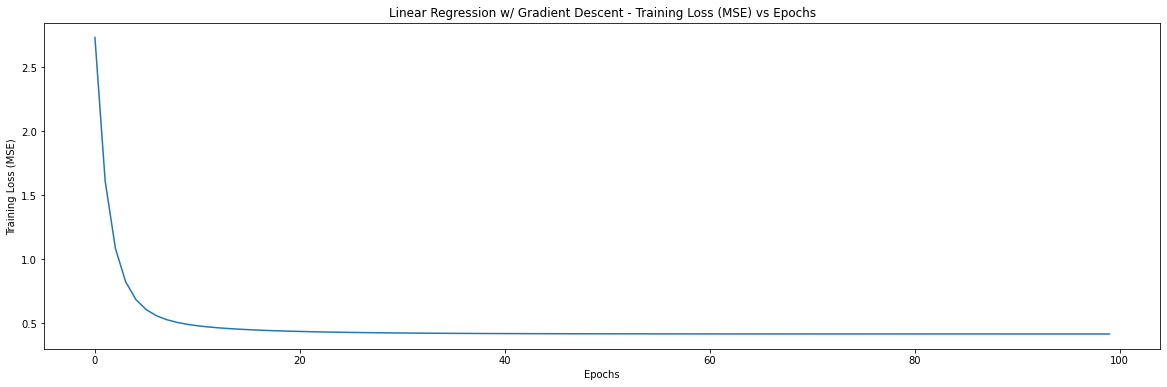

In [117]:
plt.rcParams["figure.figsize"] = (20, 6)
plt.title("Linear Regression w/ Gradient Descent - Training Loss (MSE) vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Training Loss (MSE)")
plt.plot(costs)

In [100]:
train_predictions = np.dot(x_train, theta)

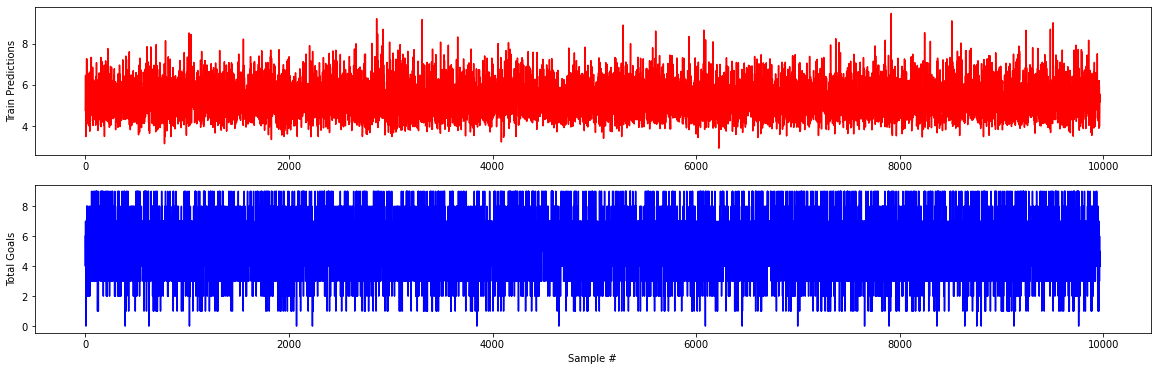

In [101]:
# denoarmalize predictions
train_predictions = [(t_i * original_std["totalGoals"]) + original_mean["totalGoals"] for t_i in train_predictions]
t_train = [(ti * original_std["totalGoals"]) + original_mean["totalGoals"] for ti in t_train]

plt.plot(train_predictions, 'o')
plt.plot(t_train, 'g')


plt.subplot(211)
plt.plot(train_predictions, 'r-')
plt.ylabel('Train Predictions')
plt.subplot(212)
plt.plot(t_train, 'b-')
plt.ylabel('Total Goals')
plt.xlabel('Sample #')
plt.show()


array([[<AxesSubplot:title={'center':'Prediction Dist. (Train)'}>,
        <AxesSubplot:title={'center':'Target Dist. (Train)'}>]],
      dtype=object)

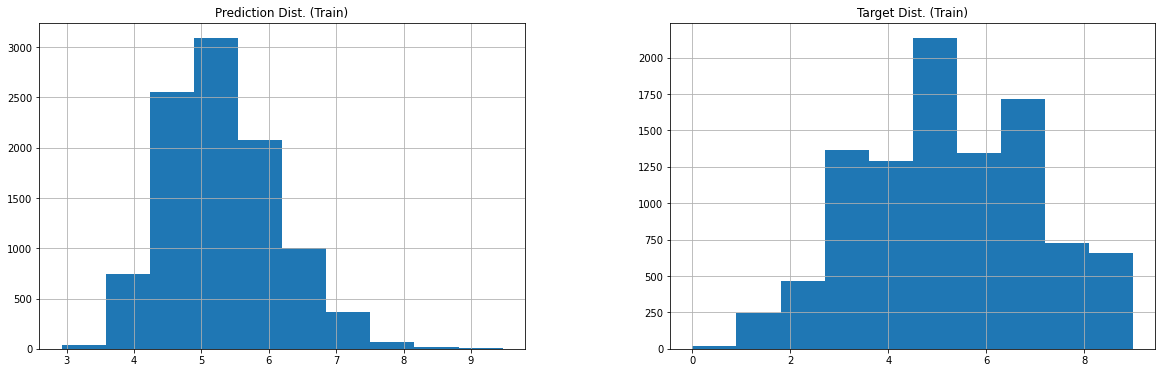

In [102]:
pred_and_targets_df = pd.DataFrame({'Prediction Dist. (Train)': train_predictions, 'Target Dist. (Train)': t_train})
pred_and_targets_df.hist()

### Test Weights Against Unseen Data

In [103]:
test_predictions = np.dot(x_test, theta)

test_predictions = [(t_i * original_std["totalGoals"]) + original_mean["totalGoals"] for t_i in test_predictions]
t_test = [(ti * original_std["totalGoals"]) + original_mean["totalGoals"] for ti in t_test]

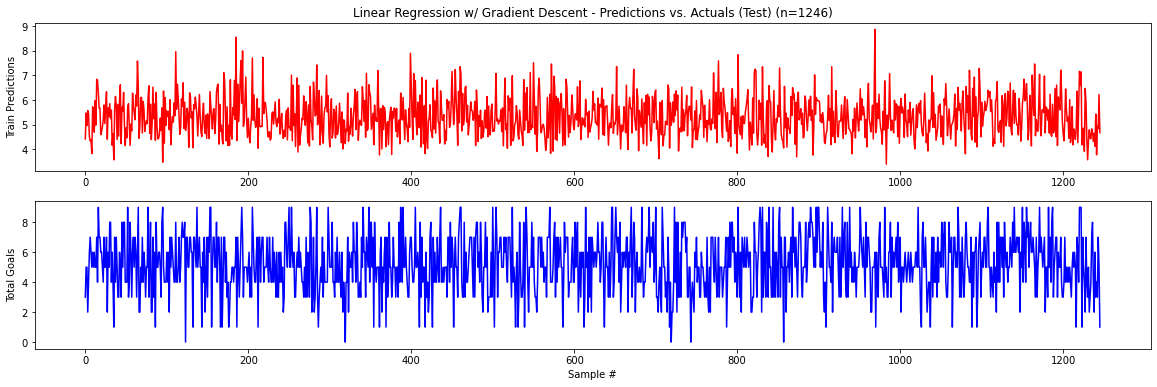

In [112]:
plt.subplot(211)
plt.title(f'Linear Regression w/ Gradient Descent - Predictions vs. Actuals (Test) (n={len(test_predictions)})')
plt.plot(test_predictions, 'r-')
plt.ylabel('Train Predictions')
plt.subplot(212)
plt.plot(t_test, 'b-')
plt.ylabel('Total Goals')
plt.xlabel('Sample #')
plt.show()

array([[<AxesSubplot:title={'center':'Prediction Distribution (Test) (n=1246)'}>,
        <AxesSubplot:title={'center':'Target Distribution (Test) (n=1246)'}>]],
      dtype=object)

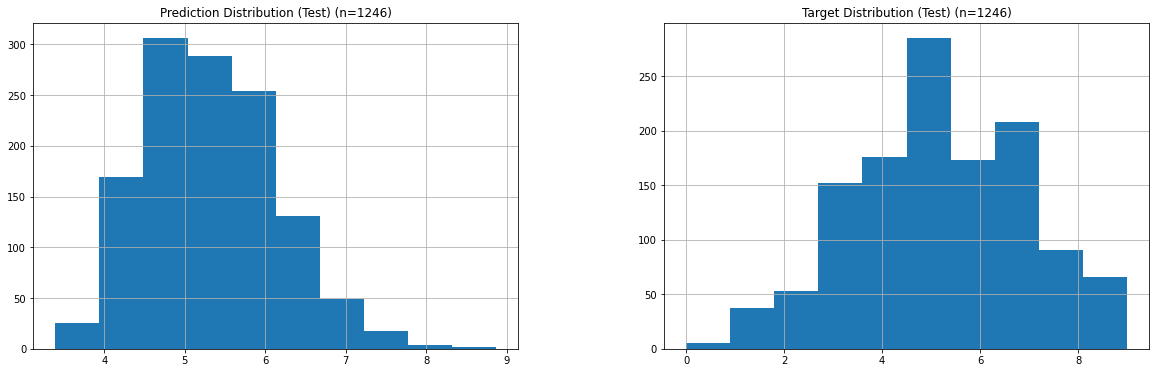

In [114]:
pred_and_targets_df = pd.DataFrame({f'Prediction Distribution (Test) (n={len(test_predictions)})': test_predictions, f'Target Distribution (Test) (n={len(test_predictions)})': t_test})
pred_and_targets_df.hist()

array([[<AxesSubplot:title={'center':'Test Loss Distribution (n=1246)'}>]],
      dtype=object)

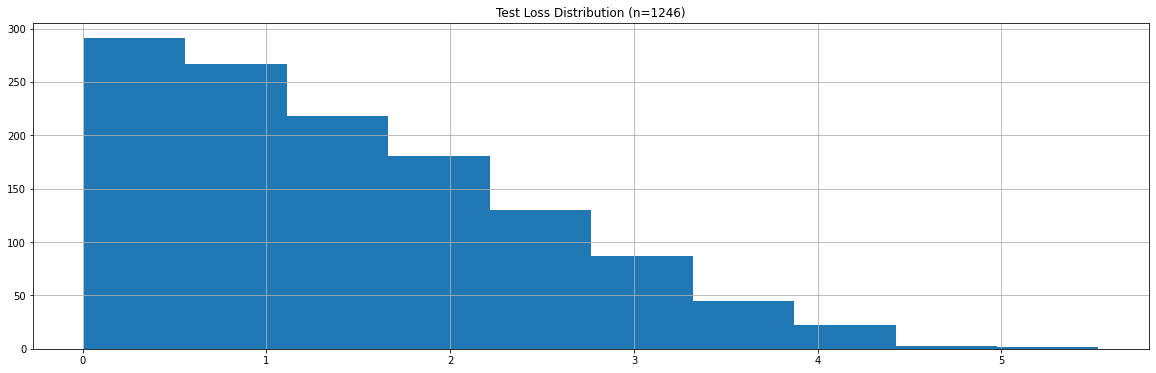

In [108]:
test_losses = [abs(t_i - p_i) for t_i, p_i in zip(t_test, test_predictions)]

test_loss_df = pd.DataFrame({f'Test Loss Distribution (n={len(test_losses)})': test_losses})
test_loss_df.hist()